# EDA
- train data와 validation data에 대해 EDA를 수행
- data 구조는 아래와 같음
    - id: 질문의 고유 id
    - question: 질문
    - answers: 답변에 대한 정보. 하나의 질문에 하나의 답변만 존재함
        - answer_start : 답변의 시작 위치
        - text: 답변의 텍스트
    - context: 답변이 포함된 문서
    - title: 문서의 제목
    - document_id: 문서의 고유 id

In [89]:
# 필요한 라이브러리 선언
from datasets import load_from_disk
import pandas as pd
import re
import json
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import unicodedata

In [90]:
# load train data, vaildation data
train_data = load_from_disk("../../data/train_dataset/train")
valid_data = load_from_disk("../../data/train_dataset/validation")
test_data = load_from_disk("../../data/test_dataset/validation")
with open("../../data/wikipedia_documents.json", "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [91]:
# change Dataset to pd.DataFrame
train_data = pd.DataFrame(train_data)
valid_data = pd.DataFrame(valid_data)
test_data = pd.DataFrame(test_data)
wiki_df = pd.DataFrame(wiki).transpose()

In [93]:
for text in test_data["question"]:
    print(text)

유령'은 어느 행성에서 지구로 왔는가?
용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?
돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?
마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?
디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?
단공류가 일반 포유류와 다르다는 것을 알 수 있는 신체 부위는?
상류 부르주아의 정치 독점을 불러일으킨 체계는?
아시노 호가 만들어진 원인은 무엇인가?
흉년이 발생하고 곳곳에 난이 일어났던 시기는?
급전궤도는 보통 무엇으로 만들어져 있는가?
클레어에게 오세아닉 815편을 타라고 말한 사람의 이름은?
제6군이 18일 동안이나 대기해야 했던 장소는?
누가 시장으로 선출되면서 트랜짓 시티 계획안이 불발되었나?
1차 대각성 운동이 일어나는데 큰 영향을 끼친 설교는 어디서 진행되었는가?
괴수로부터 메구밍을 구해준 사람은 누구인가?
슈파이어 대성당 2차 축조시에 가장 우선순위로 고려했던 천장 건축 방식은?
통대를 뽑을 수 있었던 주체는 누구인가?
이유립씨가 1970년대 중반에 본인의 글을 기고하기 시작한 곳은?
미군이 충원되지 않으면 서울이 전쟁 시작 후 2주만에 함락될 것이라 밝힌 문서는?
임경업 장군이 도를 닦은 곳으로 알려진 곳은?
화재에서 인종을 구한 공으로 귀인으로 직위가 오른 사람은?
초등학생 일기검사의 인권침해 여부를 판단하는 주체는?
콘스탄티누스가 군사 4만 명을 이끌고 침범한 나라는?
불보살이 천도할 대상은?
루돌로지스트들이 게임에서 가장 주된 것이라 주장하는 것은?
조조에게 신고한 사람도 조사해야한다고 한 것은 누구인가?
나카무라 번이 메이지 정부에 굴복하게 된 결투의 이름은 무엇인가요?
펌프가 발매된 해는 언제인가?
밀러허긴스가 법학을 전공한 곳은?
유달산에서 다도해 절경을 볼 수 있는 바위는 무엇인가?
아델리 펭귄의 목숨에 지장을 주는 사람의 업종은 무엇인가요?
이타미 역이 종착역이었을 때 존재했지만 지진 이후 없어진 것은?
석가모니 부처가 태어난 곳은 어디인가?
동맹을 

### check duplicated data

In [9]:
# title, context가 같은 항목이 1189개가 존재. 이들은 question이 다르기에 상관없음
duplicated_train = train_data[train_data.duplicated(["title", "context"], keep=False)]
duplicated_train.sort_values(by=['title'])

,title,context,question,id,answers,document_id,__index_level_0__
2604,1875년 페이지 법,미국으로 온 최초의 중국인 이민자들은 압도적으로 남성이 다수였다. 그들 대다수가 캘...,남성 노동자들은 누가 중국 남성들의 미국 이민을 거부하길 바랐는가?,mrc-0-004520,"{'answer_start': [790], 'text': ['의회 의원']}",40872,2950
978,1875년 페이지 법,미국으로 온 최초의 중국인 이민자들은 압도적으로 남성이 다수였다. 그들 대다수가 캘...,미국으로 이민 온 사람들은 누구로부터 돈을 차용할 수 있었나?,mrc-0-002627,"{'answer_start': [271], 'text': ['중개인']}",40872,1719
1395,1987년 일본 프로 야구 올스타전,전년도 일본 시리즈 정상에 오른 세이부 라이온스의 모리 마사아키 감독이 퍼시픽 리그...,야마다 히사시의 팀 감독은 누구인가?,mrc-1-000559,"{'answer_start': [28], 'text': ['모리 마사아키']}",41453,363
247,1987년 일본 프로 야구 올스타전,전년도 일본 시리즈 정상에 오른 세이부 라이온스의 모리 마사아키 감독이 퍼시픽 리그...,아난 준로 감독이 감독으로 부임한 해에 리그 우승을 차지한 팀은?,mrc-0-003206,"{'answer_start': [84], 'text': ['히로시마 도요 카프']}",41453,2106
621,1종 오류와 2종 오류,1928년에 유니버시티 칼리지 런던에 근무하던 통계학자인 예르지 네이만과 이건 피어...,"예르지 네이만, 이건 피어슨과 함께 일했던 사람은?",mrc-0-004573,"{'answer_start': [120], 'text': ['플로렌스 데이비드']}",35466,2986
...,...,...,...,...,...,...,...
1597,히지카타 도시조,"10월 20일, 에조치 와시노키에 상륙 후 도시조는 문도군 총독이 되어서 고료카쿠(...",소음으로서 도시조 군을 패닉에 빠뜨린 부대는?,mrc-0-004061,"{'answer_start': [933], 'text': ['신정부군']}",11835,2659
2243,히페리온 (위성),"보이저 2호는 토성을 지나가면서 많은 사진들을 전송했지만, 히페리온과는 멀리 떨어진...",토성과 히페리온의 사진을 촬영한 우주선의 이름은 무엇인가?,mrc-1-001684,"{'answer_start': [0], 'text': ['보이저 2호']}",14646,1105
626,히페리온 (위성),"보이저 2호는 토성을 지나가면서 많은 사진들을 전송했지만, 히페리온과는 멀리 떨어진...",2005년까지 히페리온에 가장 근접해 사진을 찍은 탐사선은 무엇인가?,mrc-0-000218,"{'answer_start': [152], 'text': ['카시니 호']}",14646,143
1449,힐,"힐은 전쟁중에 논쟁을 피하지 못했다. 병약한 체질이라서 여러 번 병치레를 했기에, ...",힐이 사관학교 병원에서 임질의 치료를 받은 때는 몇 월이었나요?,mrc-0-001005,"{'answer_start': [216], 'text': ['9월']}",9473,661


In [13]:
# question은 중복되지 않음
duplicated_train = train_data[train_data.duplicated(["question"], keep=False)]
duplicated_train.sort_values(by=['title'])

,title,context,question,id,answers,document_id,__index_level_0__


In [16]:
# answers가 중복되는 경우는 52개로 아래와 같음 
# 1. title, context, answers가 동일한 경우
# 2. context, question, answers가 동일한 경우
duplicated_train = train_data[train_data.duplicated(["answers"], keep=False)]
duplicated_train.sort_values(by=['title'])

,title,context,question,id,answers,document_id,__index_level_0__
2001,2015년 네팔 봉쇄 사태,2015년 9월 20일에는 계속 정체중이였던 네팔의 헌법 수립안이 네팔 의회에서 9...,네팔 의회 의원 중에서 투표를 포기하고 데모를 시작했던 인원은?,mrc-1-000868,"{'answer_start': [82], 'text': ['66명']}",47169,565
3205,2015년 네팔 봉쇄 사태,2015년 9월 20일에는 계속 정체중이였던 네팔의 헌법 수립안이 네팔 의회에서 9...,네팔의 헌법 수립안 투표에서 기권한 사람의 수는?,mrc-0-002753,"{'answer_start': [82], 'text': ['66명']}",47169,1805
458,강희제,강희제는 강건성세 3대에 걸쳐 문자의 옥을 시작시켜서 한족 학자들을 대거 숙청함으로...,강희제가 자식을 여러 명 낳는 데 영향을 준 자는?,mrc-0-001965,"{'answer_start': [86], 'text': ['부황 순치제']}",5031,1296
3868,강희제,강희제는 강건성세 3대에 걸쳐 문자의 옥을 시작시켜서 한족 학자들을 대거 숙청함으로...,강희제가 수녀제를 본받도록 만든 이는?,mrc-0-000199,"{'answer_start': [86], 'text': ['부황 순치제']}",5031,127
3827,광주 용두동 지석묘,"지석묘는 청동기시대의 대표적인 무덤으로 고인돌이라고도 부르며, 주로 경제력이 있거나...",지석묘는 언제 만들어졌나요?,mrc-0-000519,"{'answer_start': [5], 'text': ['청동기시대']}",47270,352
3177,교황 그레고리오 4세,"로마인 귀족 요한네스의 아들인 그레고리오는 겉보기에는 활동적이지만, 내면은 순한 성...",그레고리오를 라테라노 궁전에 감금한 사람은?,mrc-1-000371,"{'answer_start': [181], 'text': ['선거인단']}",6716,236
2588,교황 그레고리오 4세,"로마인 귀족 요한네스의 아들인 그레고리오는 겉보기에는 활동적이지만, 내면은 순한 성...",그레고리오를 라테리노 궁전에 가둔모임은?,mrc-1-001674,"{'answer_start': [181], 'text': ['선거인단']}",6716,1096
1383,교황 마르티노 1세,마르티노는 콘스탄티노폴리스에 교황 사절로 파견되어 근무하면서 동방의 사정에 통달하고...,마르티노가 교황이 되는 것을 승인했었지만 후에 후회한 사람은?,mrc-0-002492,"{'answer_start': [81], 'text': ['동로마 황제 콘스탄스 2...",6711,1631
2221,교황 마르티노 1세,마르티노는 콘스탄티노폴리스에 교황 사절로 파견되어 근무하면서 동방의 사정에 통달하고...,마르티노가 교황일 당시 교황 즉위는 누구의 허가가 필요했나?,mrc-0-000130,"{'answer_start': [81], 'text': ['동로마 황제 콘스탄스 2...",6711,80
3831,교황 우르바노 5세,우르바노 5세 치세의 큰 특징으로는 로마로 귀환하려고 노력한 점과 로마에 대한 세속...,우르바노 5세가 십자군동원을 명령한 연도는?,mrc-1-001198,"{'answer_start': [131], 'text': ['1362년']}",6773,784


In [17]:
# title, context가 같은 항목이 10개가 존재. 이들은 question이 다르기에 상관없음
duplicated_valid = valid_data[valid_data.duplicated(["title", "context"], keep=False)]
duplicated_valid.sort_values(by=['title'])

,title,context,question,id,answers,document_id,__index_level_0__
74,버트런드 러셀,러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...,러셀의 여자 친구의 종교는?,mrc-0-003677,"{'answer_start': [215], 'text': ['퀘이커 교']}",5265,2418
231,버트런드 러셀,러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...,러셀은 누구의 가족과 함께 1889년 파리 박람회에 갔는가?,mrc-0-001162,"{'answer_start': [215], 'text': ['퀘이커 교도였던 앨리스...",5265,760
129,송나라,"요나라와의 전연의 맹세에 지불한 것으로 알려진 재물은 비단 20만필, 은 10만량이...",송나라가 돈을 지불하여 피하고자 했던 것은?,mrc-0-004495,"{'answer_start': [251], 'text': ['전쟁']}",7305,2932
205,송나라,"요나라와의 전연의 맹세에 지불한 것으로 알려진 재물은 비단 20만필, 은 10만량이...",송이 금에게 바친 공물은 은 30만량과 비단 몇 필인가?,mrc-0-003437,"{'answer_start': [163], 'text': ['10만필']}",7305,2257
6,자수장,"수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...",징금수는 서양 자수의 어떤 기법과 같은 기술을 사용하는가?,mrc-0-002076,"{'answer_start': [192], 'text': ['코칭 스티치']}",19975,1366
81,자수장,"수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...",수를 놓을 때에 사용하는 기법 중 아주 작은 점으로 표현하는 방식은?,mrc-1-001132,"{'answer_start': [101], 'text': ['점수']}",19975,744
162,태양권계면,태양권계면(Heliopause)은 천문학에서 태양의 태양풍을 성간매질이 멈추게 하는...,"입자들의 속도가 줄 때, 방출되는 에너지가 만들어내는 것은?",mrc-0-003637,"{'answer_start': [435], 'text': ['충격파']}",7635,2390
189,태양권계면,태양권계면(Heliopause)은 천문학에서 태양의 태양풍을 성간매질이 멈추게 하는...,태양풍을 멈추게 하는 것과 말단 충격의 틈을 무엇이라 부르는가?,mrc-1-000714,"{'answer_start': [609], 'text': ['헬리오시스']}",7635,458
73,티칼,현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,돌을 캐고 난 빈 채석장은 어떠한 용도로 이용하였나?,mrc-0-004899,"{'answer_start': [435], 'text': ['저수지']}",12190,3183
236,티칼,현재 우리가 볼 수 있는 티칼의 모습은 펜실베이니아 대학교와 과테말라 정부의 협조 ...,공놀이 경기장 중 일부는 어디에 위치하고 있나?,mrc-0-002095,"{'answer_start': [343], 'text': [''일곱 개의 신전 광장...",12190,1378


In [63]:
# "text"에 대해 중복되는 데이터가 7677개 존재
# wiki.json을 불러와 "text"항목만 사용하기에 "text"만 확인하면 됨
duplicated_wiki = wiki_df[wiki_df.duplicated(["text"], keep=False)]
duplicated_wiki.sort_values(by=['text'])

,text,corpus_source,url,domain,title,author,html,document_id
3859,"""Robots.txt""는 이 문서를 가리킵니다. 위키백과의 Robots.txt의 파...",위키피디아,TODO,None,로봇 배제 표준,None,None,3859
8413,"""Robots.txt""는 이 문서를 가리킵니다. 위키백과의 Robots.txt의 파...",위키피디아,None,None,로봇 배제 표준,None,None,8413
6873,"""들어오지 못하게, 나가지 못하게, 나가도 쓰지 못하게”라는 삼성SDS 고유의 보안...",위키피디아,None,None,삼성SDS,None,None,6873
2319,"""들어오지 못하게, 나가지 못하게, 나가도 쓰지 못하게”라는 삼성SDS 고유의 보안...",위키피디아,TODO,None,삼성SDS,None,None,2319
3744,"""아미타불""이라는 낱말은 무량광(無量光: 헤아릴 수 없는 광명을 가진 것)의 뜻인 ...",위키피디아,TODO,None,아미타불,None,None,3744
...,...,...,...,...,...,...,...,...
6497,"힌디어(हिन्दी, Hindi)는 인도유럽어족의 인도이란어파에 속하는 언어로, 영...",위키피디아,None,None,힌디어,None,None,6497
7107,"힘이 물체의 운동 방향으로 작용하면, 물체의 운동량이 증가하고 힘이 일을 하므로 에...",위키피디아,None,None,질량-에너지 등가,None,None,7107
2553,"힘이 물체의 운동 방향으로 작용하면, 물체의 운동량이 증가하고 힘이 일을 하므로 에...",위키피디아,TODO,None,질량-에너지 등가,None,None,2553
9096,"치 셰미니 례예 낫재라.\n\n○ 子思子曰, 天命之謂性, 率性之謂道, 修道...",위키피디아,None,None,소학언해,None,None,9096


### check context, question length

In [25]:
def token_length_hist(text_data):
    tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
    token_length = []

    for text in text_data:
        token_length.append(len(tokenizer.tokenize(text)))

    plt.figure(figsize=(10,7))
    n, bin, _ = plt.hist(token_length, bins=20)
    plt.xlabel("Length of token")
    plt.ylabel("Frequency")

    for i, (rate, count) in enumerate(zip(bin, n)):
        plt.text(rate + (bin[i+1] - bin[i]) / 2, count, str(int(count)), color='black', ha='center', va='bottom')

    plt.show()

    print("max length of token : ", max(token_length))
    print("min length of token : ", min(token_length))

### context token length

Token indices sequence length is longer than the specified maximum sequence length for this model (1020 > 512). Running this sequence through the model will result in indexing errors


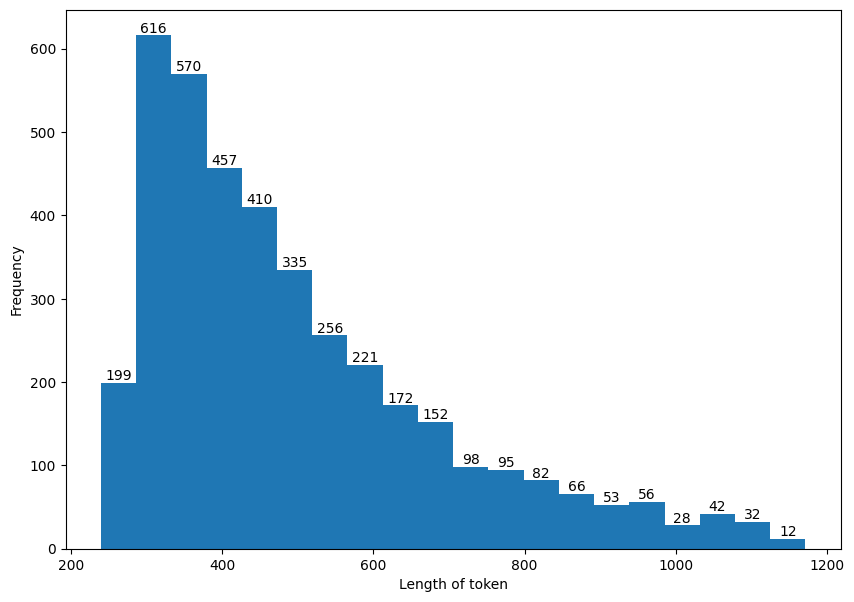

max length of token :  1172
min length of token :  239


In [26]:
token_length_hist(train_data.context)

Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors


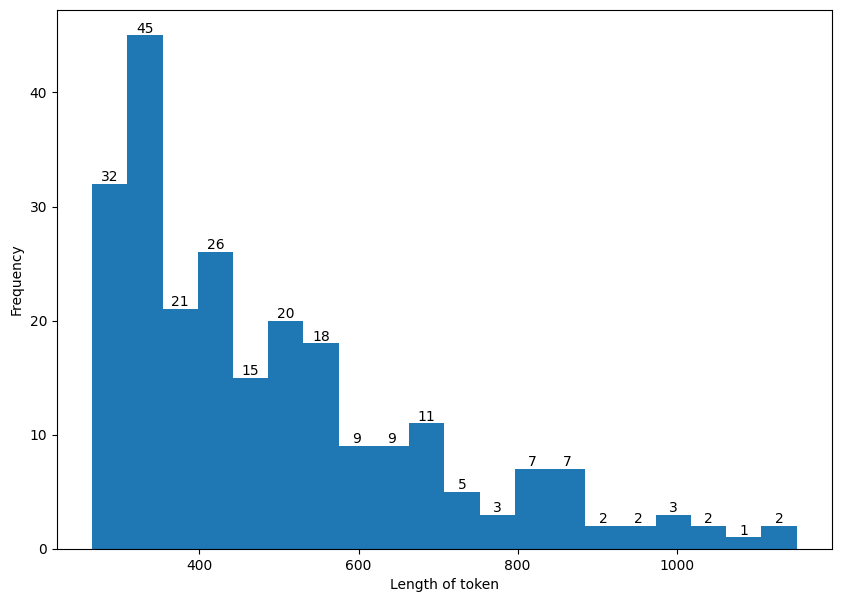

max length of token :  1151
min length of token :  265


In [27]:
token_length_hist(valid_data.context)

### question token length

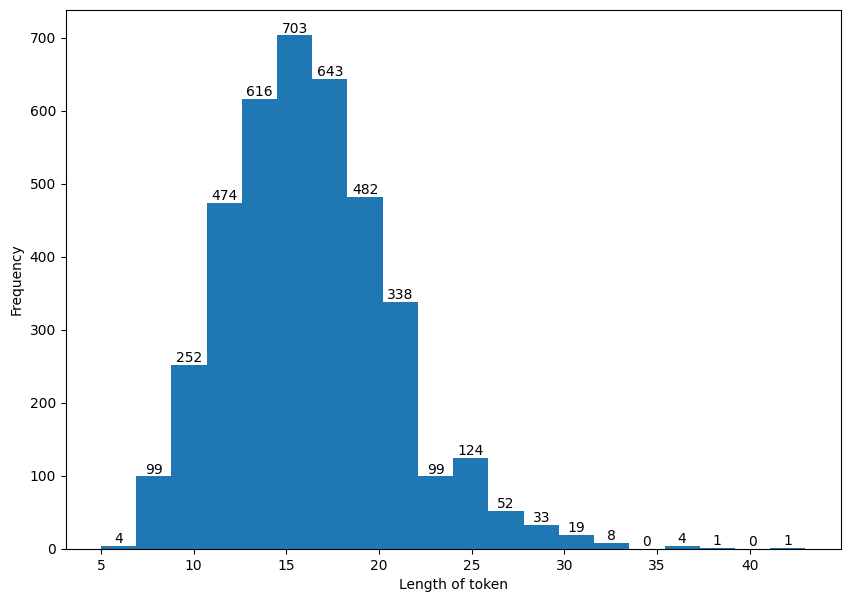

max length of token :  43
min length of token :  5


In [28]:
token_length_hist(train_data.question)

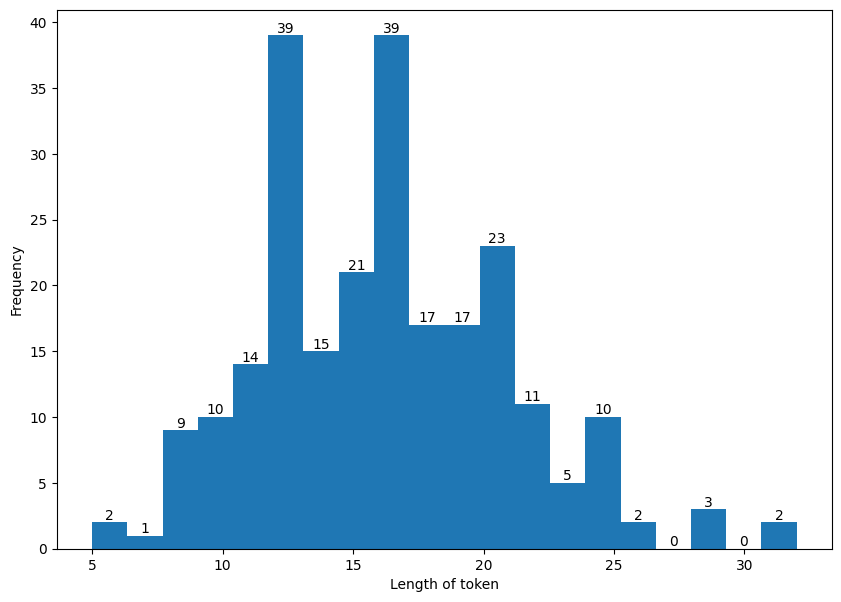

max length of token :  32
min length of token :  5


In [29]:
token_length_hist(valid_data.question)

### 전각문자, 반각문자

In [137]:
normalized_data = [unicodedata.normalize("NFKC", text) for text in train_data.context]

In [138]:
train_data.context[train_data.context != normalized_data]

46      도곡 단지 전체에 4계절 녹음과 단풍이 풍성할 수 있는 계획을 하고 인도를 넓게 확...
61      서양 근세의 교육은 14세기에서 17세기 초반 까지의 유럽 세계의 교육활동을 의미한...
62      프랑스 민요는 프랑스의 노래로 이른바 샹송이 유명한 것에 비하여, 극히 일부만이 알...
72      도쿄 마루노우치에 있는 토자이 상사 경영전략부에 근무하는 노다 나오코는 근무 경력 ...
122     수심 20 m - 30 m의 연안의 해안 절벽이나 산호초에서 떼를 지어 서식하 내만...
                              ...                        
3806    보니파시오 4세는 발레리아 태생의 마르시인이자 의사인 요한네스의 아들이다. 교황 보...
3905    버러 마켓은 수요일과 목요일에 아침 10시부터 오후 5시까지, 토요일에 아침 8시부...
3916    미하일 4세 파플라고니아인(그리스어: Μιχαήλ Δ΄ Παφλαγών, 1010년...
3923    프랑스 민요는 프랑스의 노래로 이른바 샹송이 유명한 것에 비하여, 극히 일부만이 알...
3936    1868년 도바 후시미 전투에서 구 막부군이 신정부군에게 패하면서, 도쿠가와 요시노...
Name: context, Length: 171, dtype: object

In [154]:
def normalized_context(dataset):
    def normalize(example):
        return {"context": unicodedata.normalize("NFKC", example["context"])}
    return dataset.map(normalize)

In [155]:
normalized_train = normalized_context(train_data)

Map: 100%|██████████| 3952/3952 [00:00<00:00, 7024.74 examples/s]


In [156]:
train_pd = pd.DataFrame(train_data)
normalized_pd = pd.DataFrame(normalized_train)

In [157]:
normalized_pd[normalized_pd["context"] != train_pd["context"]]

,title,context,question,id,answers,document_id,__index_level_0__
46,삼성 타워팰리스의 계획,도곡 단지 전체에 4계절 녹음과 단풍이 풍성할 수 있는 계획을 하고 인도를 넓게 확...,초고층 주거에서 차량과 사람의 활동 범위 중복을 최소화하는 장치는?,mrc-0-005170,"{'answer_start': [663], 'text': ['덱']}",44302,3366
61,서양 근세의 교육,서양 근세의 교육은 14세기에서 17세기 초반 까지의 유럽 세계의 교육활동을 의미한...,신 중심에서 인간 중심 사회로의 변화가 시작된 시기는?,mrc-1-000812,"{'answer_start': [11], 'text': ['14세기']}",31359,525
62,프랑스 민요,"프랑스 민요는 프랑스의 노래로 이른바 샹송이 유명한 것에 비하여, 극히 일부만이 알...",각절마다 미롱통 소리가 나오는 노래는?,mrc-0-003404,"{'answer_start': [317], 'text': ['〈마브루공(公)〉']}",26988,2233
72,아네고,도쿄 마루노우치에 있는 토자이 상사 경영전략부에 근무하는 노다 나오코는 근무 경력 ...,나오코는 미아코토와 소개팅을 한 후 누구와 집에 돌아갔는가?,mrc-0-001215,"{'answer_start': [501], 'text': ['하세가와 마나미']}",22025,794
122,자리돔,수심 20 m - 30 m의 연안의 해안 절벽이나 산호초에서 떼를 지어 서식하 내만...,"매년 해수온이 올라가는 현상으로 인해, 자리돔의 서식지가 어디까지 확장되었는가?",mrc-1-000736,"{'answer_start': [439], 'text': ['대한민국 동해']}",18532,475
...,...,...,...,...,...,...,...
3806,교황 보니파시오 4세,보니파시오 4세는 발레리아 태생의 마르시인이자 의사인 요한네스의 아들이다. 교황 보...,보니파시오 4세가 사망한 해는?,mrc-1-000861,"{'answer_start': [128], 'text': ['615년']}",6704,558
3905,버러 마켓,"버러 마켓은 수요일과 목요일에 아침 10시부터 오후 5시까지, 토요일에 아침 8시부...",버러 마켓은 본래 어느 다리의 끝부분과 맞닿아 있었나요?,mrc-0-002589,"{'answer_start': [166], 'text': ['런던브리지']}",46656,1692
3916,미하일 4세,"미하일 4세 파플라고니아인(그리스어: Μιχαήλ Δ ́ Παφλαγών, 1010...",제국과 메시나를 두고 전쟁을 벌인 민족은?,mrc-0-005146,"{'answer_start': [789], 'text': ['사라센인']}",14268,3349
3923,프랑스 민요,"프랑스 민요는 프랑스의 노래로 이른바 샹송이 유명한 것에 비하여, 극히 일부만이 알...",캐나다 민요는 주로 어느 나라의 민요와 똑같은가?,mrc-0-000334,"{'answer_start': [862], 'text': ['프랑스']}",26988,226


### check korean ratio
- wikipedia_documents.json 파일을 분석

In [33]:
wiki["0"]

{'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.',
 'corpus_source': '위키피디아',
 'url': 'TODO',
 'domain': None,
 'title': '나라 목록',
 'author': None,
 'html': None,
 'document_id': 0}

In [79]:
wiki_df["kor_ratio"] = "None"
korean_ratio = []
for idx, text in enumerate(wiki_df["text"]):
    processed_text = re.sub(r"[\n\s]", "", text)
    p = re.compile("[가-힣]")
    wiki_df.iloc[idx, 8] = len(p.findall(processed_text)) / len(processed_text) *100
    korean_ratio.append(wiki_df.iloc[idx, 8])

In [80]:
wiki_df

,text,corpus_source,url,domain,title,author,html,document_id,kor_ratio
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0,91.891892
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1,90.221187
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2,87.585856
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3,85.991379
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4,90.136986
...,...,...,...,...,...,...,...,...,...
60608,"오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60608,81.991525
60609,"1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60609,74.174174
60610,박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60610,81.22449
60611,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,위키피디아,None,None,단결권 및 단체교섭권 협약,None,None,60611,62.025316


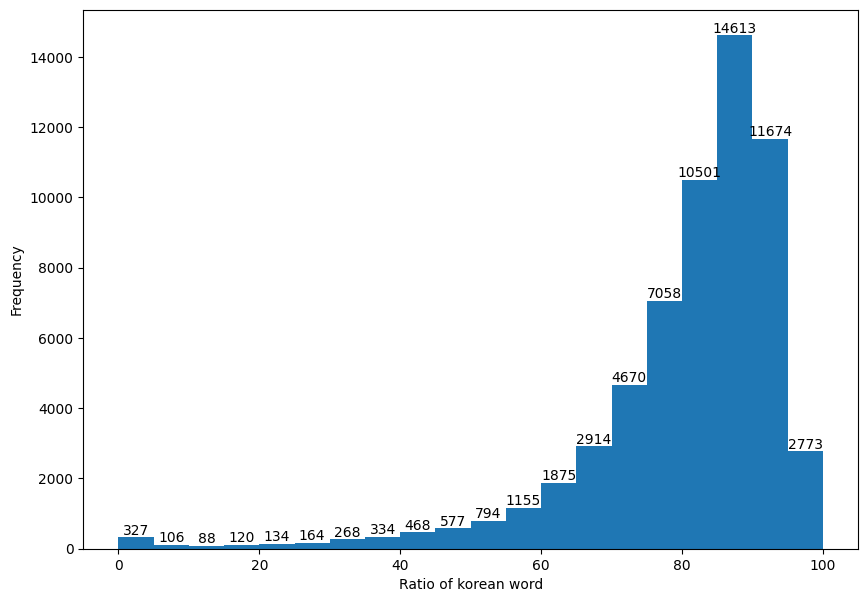

max ratio :  100.0
min ratio :  0.0


In [66]:
plt.figure(figsize=(10,7))
n, bin, _ = plt.hist(korean_ratio, bins=20)
plt.xlabel("Ratio of korean word")
plt.ylabel("Frequency")

for i, (rate, count) in enumerate(zip(bin, n)):
    plt.text(rate + (bin[i+1] - bin[i]) / 2, count, str(int(count)), color='black', ha='center', va='bottom')

plt.show()

print("max ratio : ", max(korean_ratio))
print("min ratio : ", min(korean_ratio))

### 특수문자 확인
- answers에 존재하는 다른 나라의 언어는 지우지 않아야 함

In [35]:
special_list = []
for text in train_data.answers:
    special_char = re.findall(r"[^a-zA-Z0-9가-힣ㄱ-ㅎㅏ-ㅣぁ-ゔァ-ヴー々〆〤一-龥\s]", text["text"][0])
    special_list.append(special_char)

In [36]:
s_list = set([item for sublist in special_list for item in sublist])

In [37]:
print(s_list)

{'‘', '%', '"', '\xad', '!', '」', '+', '(', '〉', '>', ')', '・', '/', '「', '≫', '~', '∧', '”', ':', "'", '·', 'ä', '°', '》', '<', ',', '≪', '.', '“', '『', '＜', '〈', '’', '＞', '』', '《', '-'}


In [55]:
import sys
sys.path.append("/data/ephemeral/code/")
from data_preprocessing import *